In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gzreduction.vote_sources.panoptes_exports import export_to_responses
from gzreduction.vote_sources.panoptes_exports import aggregate
from gzreduction.schemas.euclid_schema import euclid_schema

In [9]:

schema = euclid_schema

In [10]:
date_str = '2024_10_22'

In [11]:
# classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid-development-classifications_' + date_str + '.csv'
# aggregated_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid_development_reduced_votes_' + date_str + '.csv'

classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid-challenge-classifications_' + date_str + '.csv'
aggregated_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid_challenge_reduced_votes_' + date_str + '.csv'

In [12]:
# nrows = 10000
nrows = None
clf = pd.read_csv(classification_export_loc, nrows=nrows)
clf

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,575637319,MikeWalmsley,290475.0,dd88d36f908c3c7a48d4,27100,Euclid Challenge,1.1,2024-08-01 12:31:20 UTC,NaN,NaN,"{""source"":""api"",""session"":""bb29dd0cbc265ed2c59...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101103135"":{""retired"":{""id"":131273171,""workf...",101103135
1,575637443,MikeWalmsley,290475.0,dd88d36f908c3c7a48d4,27100,Euclid Challenge,1.1,2024-08-01 12:33:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""bb29dd0cbc265ed2c59...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101101075"":{""retired"":{""id"":131273208,""workf...",101101075
2,575637955,unravel,2403423.0,8245306c2a1ba3be7421,27100,Euclid Challenge,1.1,2024-08-01 12:38:36 UTC,NaN,NaN,"{""source"":""api"",""session"":""6b06594340d3b205cdd...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101093977"":{""retired"":{""id"":131273284,""workf...",101093977
3,575638057,unravel,2403423.0,8245306c2a1ba3be7421,27100,Euclid Challenge,1.1,2024-08-01 12:39:45 UTC,NaN,NaN,"{""source"":""api"",""session"":""6b06594340d3b205cdd...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101091891"":{""retired"":{""id"":131273307,""workf...",101091891
4,575640326,not-logged-in-b047cf5baa218f196bc0,NaN,b047cf5baa218f196bc0,27100,Euclid Challenge,1.1,2024-08-01 12:55:02 UTC,NaN,NaN,"{""source"":""api"",""session"":""399725f27fd2dd1f611...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101086153"":{""retired"":{""id"":131273544,""workf...",101086153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475761,590215326,Afonsocvn,2783137.0,6502a57f4f771e03bdcb,27100,Euclid Challenge,1.1,2024-10-11 17:36:06 UTC,NaN,NaN,"{""source"":""api"",""session"":""a78016c27b568562f17...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101577358"":{""retired"":{""id"":132629976,""workf...",101577358
475762,590215376,Afonsocvn,2783137.0,6502a57f4f771e03bdcb,27100,Euclid Challenge,1.1,2024-10-11 17:36:19 UTC,NaN,NaN,"{""source"":""api"",""session"":""a78016c27b568562f17...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101564396"":{""retired"":null,""!filename"":""d283...",101564396
475763,590215423,not-logged-in-cbfc32939b2b095ccf29,NaN,cbfc32939b2b095ccf29,27100,Euclid Challenge,1.1,2024-10-11 17:36:35 UTC,NaN,NaN,"{""source"":""api"",""session"":""8dfbe00a32e2e496ade...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101569824"":{""retired"":null,""!filename"":""bd1f...",101569824
475764,590215460,not-logged-in-5e75786b56b0791f49ff,NaN,5e75786b56b0791f49ff,27100,Euclid Challenge,1.1,2024-10-11 17:36:47 UTC,NaN,NaN,"{""source"":""api"",""session"":""1bda528104a01167a38...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101564395"":{""retired"":null,""!filename"":""036e...",101564395


In [13]:
len(clf['user_name'].unique())

8434

In [14]:
counts_per = clf['user_name'].value_counts()[:40]

(1, 13517.771992348704)

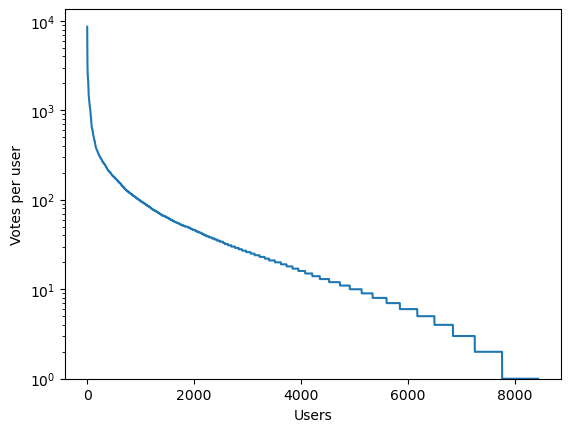

In [15]:

plt.plot(clf['user_name'].value_counts().sort_values(ascending=False).values)
plt.yscale('log')
plt.xlabel('Users')
plt.ylabel('Votes per user')
plt.ylim(1, None)

Text(0, 0.5, 'Cum. votes by those volunteers')

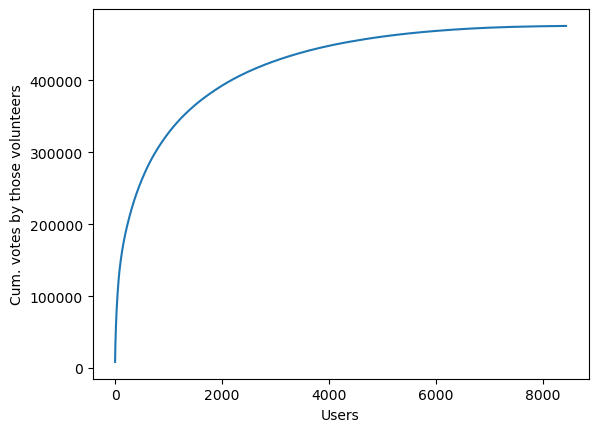

In [16]:

plt.plot(clf['user_name'].value_counts().sort_values(ascending=False).cumsum().values)
# plt.yscale('log')
plt.xlabel('Users')
plt.ylabel('Cum. votes by those volunteers')

In [17]:
expert_usernames = [
    'lauraleuzzi',
    'solfra',
    'Clarkguilty',
    'giulsp',
    'cmk24',
    'mhuertascompany',
    'gstevens',
    'marleau',
    'Berta_MB',
    'susan pyne',
    'helenecourtois',
    'gracca',
    'juliekatona',
    'MinaEnceladus',
    'LauraBisigello',
    'OliverMueller',
    'ThaiTran',
    'irisso',
    'antoniolamarca',
    'MikeWalmsley'
]
expert_usernames = [x.lower() for x in expert_usernames]
clf['expert'] = clf['user_name'].str.lower().isin(expert_usernames)
# clf['expert'].value_counts()
clf.query('expert').groupby('user_name')['classification_id'].count().sort_values(ascending=False)

user_name
solfra             369
ThaiTran           233
MinaEnceladus      188
antoniolamarca      86
mhuertascompany     59
OliverMueller       51
juliekatona         47
giulsp              32
helenecourtois      28
MikeWalmsley        14
irisso              12
lauraleuzzi         10
marleau             10
Berta_MB             6
cmk24                4
gstevens             3
clarkguilty          1
Name: classification_id, dtype: int64

Text(0, 0.5, 'Cum. votes by those astronomers')

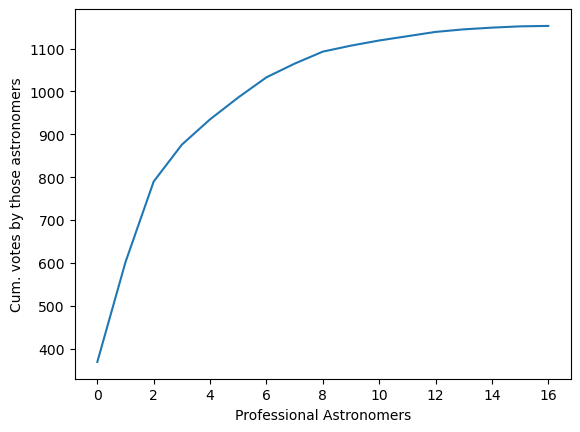

In [18]:
import matplotlib.pyplot as plt
plt.plot(clf.query('expert')['user_name'].value_counts().sort_values(ascending=False).cumsum().values)
# plt.yscale('log')
plt.xlabel('Professional Astronomers')
plt.ylabel('Cum. votes by those astronomers')
# pretty similar, maybe less extreme low count tail

In [19]:
def get_euclid_subject_id(subject_data):
    loaded = json.loads(subject_data)
    inner_dict = loaded[list(loaded.keys())[0]]
    # return inner_dict['Filename']
    return inner_dict['!filename']

In [20]:
clf['id_str'] = clf['subject_data'].apply(get_euclid_subject_id)
clf['id_str'] 

0         bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...
1         98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...
2         18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...
3         7e9871caaeccc9e709002b24f8ff097cb47516de27f609...
4         c52a8096a07e5a8af5339408267172ebcab0041a802d28...
                                ...                        
475761    b870f38e16f3648a65c7a80ab4656149aef50710797284...
475762    d28366dae1a7aeb3523156cdeb1bb7923784a93674ac3c...
475763    bd1f534233b8c4d563ec8a896de47d098074ea263b07c3...
475764    036e59d8b8cde72106edbb03a2cb2d99ceea9b42f4441a...
475765    3760b0a0839263e288ea251af381a032a3e7904c61e898...
Name: id_str, Length: 475766, dtype: object

In [21]:
clf.columns.values

array(['classification_id', 'user_name', 'user_id', 'user_ip',
       'workflow_id', 'workflow_name', 'workflow_version', 'created_at',
       'gold_standard', 'expert', 'metadata', 'annotations',
       'subject_data', 'subject_ids', 'id_str'], dtype=object)

In [22]:
len(clf)

475766

In [23]:
# workflows = [26524]
workflows = [27100]
clf = clf[clf['workflow_id'].isin(workflows)]
assert len(clf) > 0

In [24]:
clf['created_at'] = pd.to_datetime(clf['created_at'])

In [25]:
clf_dt = clf.pivot_table(index='created_at', columns='workflow_id', values='id_str', aggfunc='count', fill_value=0)

In [26]:

clf_dt_r = clf_dt.resample('2H').sum()[27100]
clf_dt_r

created_at
2024-08-01 12:00:00+00:00     324
2024-08-01 14:00:00+00:00    3217
2024-08-01 16:00:00+00:00    3248
2024-08-01 18:00:00+00:00    3201
2024-08-01 20:00:00+00:00    3193
                             ... 
2024-10-11 08:00:00+00:00     274
2024-10-11 10:00:00+00:00     361
2024-10-11 12:00:00+00:00     274
2024-10-11 14:00:00+00:00     572
2024-10-11 16:00:00+00:00     717
Freq: 2H, Name: 27100, Length: 855, dtype: int64

In [27]:
clf['created_at'].max() - clf['created_at'].min()

Timedelta('71 days 05:05:34')

(0.0, 24533.05)

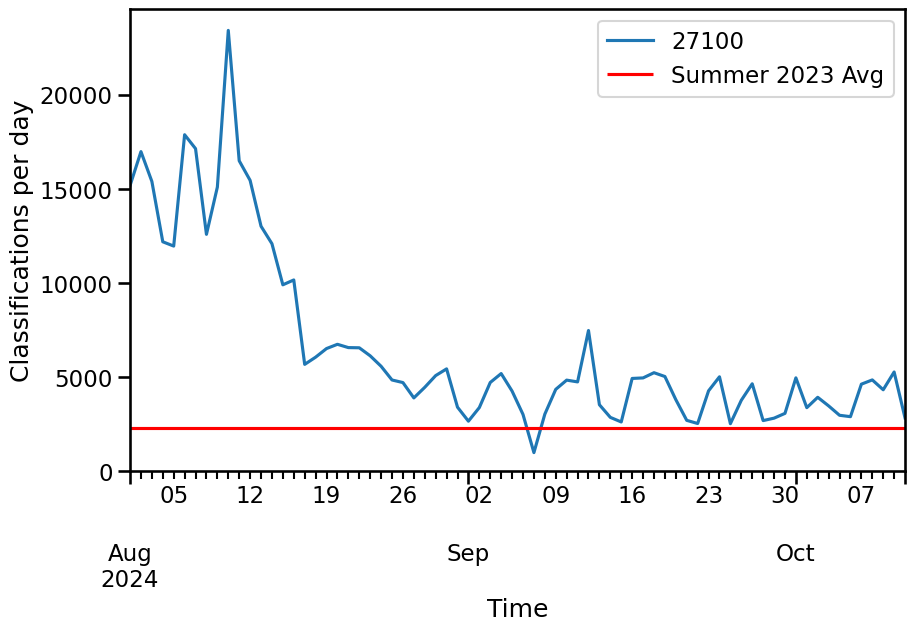

In [28]:
import seaborn as sns
sns.set_context('talk')
clf_dt_r = clf_dt.resample('1D').sum().plot(figsize=(10, 6))
# plt.plot(clf_dt_r.index, clf_dt_r.values)
plt.xlabel('Time')
plt.ylabel('Classifications per day')
# 744 hours in august
# plt.hlines(y=150000/(31*24), xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='g', label='Aug 2022 Avg')
# plt.hlines(y=71000/(31*24), xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='r', label='Aug 2023 Avg')
# plt.hlines(y=670, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='k', linestyle='--', label='Euclid Avg')
# plt.hlines(y=670, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='k', linestyle='--', label='Euclid Late Avg')
# plt.legend('',frameon=False)

# plt.axvline(pd.to_datetime('2024-08-01 13:00:00'), color='r', linestyle='--')
# plt.axvline(pd.to_datetime('2024-08-01 19:00:00'), color='r', linestyle='--')
plt.hlines(y=2300, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='r', label='Summer 2023 Avg')
plt.legend()
plt.ylim([0, None])

In [29]:
len(clf)/(7*24)

2831.940476190476

In [30]:
# clf['time_since_start'] = clf['created_at'] - clf['created_at'].min()

In [31]:
# clf['days_since_start'] = np.around(clf['time_since_start'].dt.total_seconds() / (24*3600), 1)

In [32]:
# clf_grouped = clf.groupby('days_since_start').agg({'user_name': 'count'}).reset_index()

In [33]:
clf['annotations'] = clf['annotations'].apply(json.loads)

In [34]:
# df = export_to_responses.explode_annotations(clf, exclude_tasks=['T10'])
# df

In [35]:
# plt.hist(clf['annotations'].apply(len))
clf['annotations'].isna().sum()

0

In [36]:
clf['annotations'].iloc[0]

[{'task': 'T0',
  'task_label': 'Is the galaxy simply smooth and rounded, with no sign of a disk?',
  'value': '![features_or_disk_new.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/1ec52a74-9e49-4579-91ff-0140eb5371e6.png =60x) Features or Disk'},
 {'task': 'T2',
  'task_label': 'Could this be a disk viewed edge-on?',
  'value': '![feature_or_disk.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/f353f2f1-a47e-439d-b9ca-020199162a79.png =60x) No - Something Else'},
 {'task': 'T4',
  'task_label': 'Is there a bar feature through the centre of the galaxy?',
  'value': '![bar_strong_sidebyside_acwacw_200x100.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/4b9b5758-ca37-47bd-bb24-ca0933f45d1b.png =120x60) Strong Bar'},
 {'task': 'T5',
  'task_label': 'Is there any sign of a spiral arm pattern?',
  'value': '![rounded.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/944

In [37]:
df = export_to_responses.explode_annotations(clf, exclude_tasks=None)  # now includes T10, rare features, as well
df

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T0,"Is the galaxy simply smooth and rounded, with ...",![features_or_disk_new.png](https://panoptes-u...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T2,Could this be a disk viewed edge-on?,![feature_or_disk.png](https://panoptes-upload...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T4,Is there a bar feature through the centre of t...,![bar_strong_sidebyside_acwacw_200x100.png](ht...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T5,Is there any sign of a spiral arm pattern?,![rounded.png](https://panoptes-uploads.zooniv...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T8,"Is there a central bulge? If so, how large is ...",![bulge_icon_moderate_bulge.png](https://panop...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
...,...,...,...,...,...,...,...,...,...
475764,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,036e59d8b8cde72106edbb03a2cb2d99ceea9b42f4441a...,NaN,590215460,2024-10-11 17:36:47+00:00,101564395,1.1
475765,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,3760b0a0839263e288ea251af381a032a3e7904c61e898...,2782982.0,590215485,2024-10-11 17:36:54+00:00,101572504,1.1
475765,T1,How rounded is it?,![in_between_shaped.png](https://panoptes-uplo...,3760b0a0839263e288ea251af381a032a3e7904c61e898...,2782982.0,590215485,2024-10-11 17:36:54+00:00,101572504,1.1
475765,T11,Is the galaxy merging or disturbed?,![merger_icons_merger.png](https://panoptes-up...,3760b0a0839263e288ea251af381a032a3e7904c61e898...,2782982.0,590215485,2024-10-11 17:36:54+00:00,101572504,1.1


In [38]:
# del clf # save memory

In [39]:
rare = df.query('task == "T10"')  # handle separately
assert len(rare) > 0
rare

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
475761,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,b870f38e16f3648a65c7a80ab4656149aef50710797284...,2783137.0,590215326,2024-10-11 17:36:06+00:00,101577358,1.1
475762,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,d28366dae1a7aeb3523156cdeb1bb7923784a93674ac3c...,2783137.0,590215376,2024-10-11 17:36:19+00:00,101564396,1.1
475763,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,bd1f534233b8c4d563ec8a896de47d098074ea263b07c3...,NaN,590215423,2024-10-11 17:36:35+00:00,101569824,1.1
475764,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,036e59d8b8cde72106edbb03a2cb2d99ceea9b42f4441a...,NaN,590215460,2024-10-11 17:36:47+00:00,101564395,1.1


In [40]:

df = df.query('task != "T10"')

In [41]:
question = schema.get_question_from_raw_name('T0')
# question.get_answer_names()
question.get_raw_answer_names()

['smooth', 'features or disk', 'star, artifact, or bad zoom']

In [42]:
cleaned = export_to_responses.clean_exploded_annotations(df, schema)

In [43]:
len(cleaned)  # 551945 on 8th Aug, 1278819 on Aug 20th, 1564846 at end-of-August, 1996732 23rd Sept

2327159

In [44]:
aggregated = aggregate.responses_to_reduced_votes(cleaned.reset_index(drop=True), schema)

/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may give nans?
/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may giv

In [45]:
aggregated

question_response,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_artifact_fraction,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction,artifact_ghost_fraction
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,1,1,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,0,3,0,0,0,0,0,0,...,1.0,0.0,0.0,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,1,1,2,0,0,0,0,...,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,000203f7ec0c2aef5582fd5e2ca29eb8f7e253b5cb3584...,1,2,1,0,1,0,0,2,0,...,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91997,fffd74d45a669c041b9159b29141b50f75dbf9c4af0260...,5,0,0,5,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
91998,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
91999,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
92000,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [46]:
# merge in subject id

aggregated = aggregated.merge(clf[['id_str', 'subject_ids']].drop_duplicates(), on='id_str', how='left')
aggregated = aggregated.rename(columns={'subject_ids': 'subject_id'})

In [47]:
aggregated

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction,artifact_ghost_fraction,subject_id
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,1,1,0,0,1,0,0,1,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101552209
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,0,3,0,0,0,0,0,0,...,0.0,0.0,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,101564291
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101084770
3,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,1,1,2,0,0,0,0,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101561303
4,000203f7ec0c2aef5582fd5e2ca29eb8f7e253b5cb3584...,1,2,1,0,1,0,0,2,0,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101582293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91997,fffd74d45a669c041b9159b29141b50f75dbf9c4af0260...,5,0,0,5,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101090409
91998,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101547106
91999,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101084827
92000,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,101117763


In [48]:
aggregated.to_csv(aggregated_loc, index=False)

In [49]:
aggregated['smooth-or-featured_total-votes']

0        2
1        3
2        5
3        4
4        4
        ..
91997    5
91998    5
91999    5
92000    5
92001    5
Name: smooth-or-featured_total-votes, Length: 92002, dtype: int64

<Axes: >

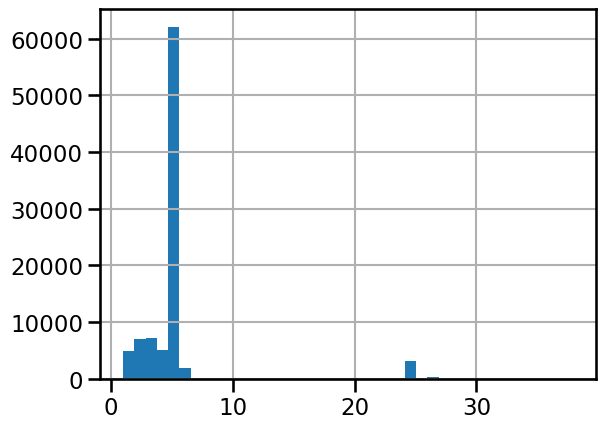

In [50]:
aggregated['smooth-or-featured_total-votes'].hist(bins=40)

Text(0, 0.5, 'Galaxies')

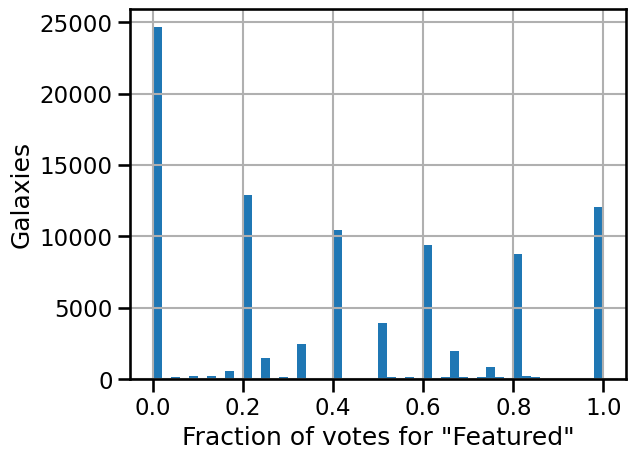

In [51]:
aggregated['smooth-or-featured_featured-or-disk_fraction'].hist(bins=50)
plt.xlabel('Fraction of votes for "Featured"')
plt.ylabel('Galaxies')

In [52]:
rare['value'].isna().sum()

0

In [53]:
rare['value'].value_counts()

value
[![no.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/096879e1-12ae-4df8-abb8-d4a93bc7797f.png =35x) Nothing Unusual]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [54]:
len(rare)

424593

In [55]:
rare

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
475761,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,b870f38e16f3648a65c7a80ab4656149aef50710797284...,2783137.0,590215326,2024-10-11 17:36:06+00:00,101577358,1.1
475762,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,d28366dae1a7aeb3523156cdeb1bb7923784a93674ac3c...,2783137.0,590215376,2024-10-11 17:36:19+00:00,101564396,1.1
475763,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,bd1f534233b8c4d563ec8a896de47d098074ea263b07c3...,NaN,590215423,2024-10-11 17:36:35+00:00,101569824,1.1
475764,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,036e59d8b8cde72106edbb03a2cb2d99ceea9b42f4441a...,NaN,590215460,2024-10-11 17:36:47+00:00,101564395,1.1


In [56]:
# explode *again* to unpack the list in value
# rare.set_index('classification_id', inplace=True)
rare_exploded = rare.explode(['value'])  # df method preserves index
rare_exploded

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,![irregular.png](https://panoptes-uploads.zoon...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,![overlapping.png](https://panoptes-uploads.zo...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
475761,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,b870f38e16f3648a65c7a80ab4656149aef50710797284...,2783137.0,590215326,2024-10-11 17:36:06+00:00,101577358,1.1
475762,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,d28366dae1a7aeb3523156cdeb1bb7923784a93674ac3c...,2783137.0,590215376,2024-10-11 17:36:19+00:00,101564396,1.1
475763,T10,Do you see any of these rare features?,![overlapping.png](https://panoptes-uploads.zo...,bd1f534233b8c4d563ec8a896de47d098074ea263b07c3...,NaN,590215423,2024-10-11 17:36:35+00:00,101569824,1.1
475764,T10,Do you see any of these rare features?,![irregular.png](https://panoptes-uploads.zoon...,036e59d8b8cde72106edbb03a2cb2d99ceea9b42f4441a...,NaN,590215460,2024-10-11 17:36:47+00:00,101564395,1.1


In [57]:
rare_exploded['value'] = rare_exploded['value'].apply(export_to_responses.sanitise_string)

In [58]:
rare_exploded['value'].value_counts()

value
nothing unusual    313367
something else      32313
overlapping         28234
irregular           28133
ring                20440
dust lane           15128
lens or arc         10228
Name: count, dtype: int64

In [59]:
rare_exploded['value'] = rare_exploded['value'].str.replace(' ', '_')

In [60]:
rare_pivoted = rare_exploded.pivot_table(index='id_str', columns='value', aggfunc='size', fill_value=0).reset_index()
rare_pivoted

value,id_str,dust_lane,irregular,lens_or_arc,nothing_unusual,overlapping,ring,something_else
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,0,1,0,1,0,0,0
1,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,0,0,0,4,0,0,1
2,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,0,0,0,3,0,0,0
3,000203f7ec0c2aef5582fd5e2ca29eb8f7e253b5cb3584...,0,0,0,2,0,1,0
4,00025007df9c7e1ced4aa2c48685c253a5205519098cad...,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...
89807,fffd74d45a669c041b9159b29141b50f75dbf9c4af0260...,0,0,0,5,0,0,0
89808,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,1,1,4,0,1,0
89809,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,0,0,5,0,0,0
89810,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,0,0,0,5,0,0,0


In [61]:
rare_answers = rare_pivoted.columns[1:]
rare_answers

Index(['dust_lane', 'irregular', 'lens_or_arc', 'nothing_unusual',
       'overlapping', 'ring', 'something_else'],
      dtype='object', name='value')

In [62]:
rare_merged = pd.merge(aggregated, rare_pivoted, on='id_str', how='inner', validate='one_to_one')
rare_merged

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,artifact_other_fraction,artifact_ghost_fraction,subject_id,dust_lane,irregular,lens_or_arc,nothing_unusual,overlapping,ring,something_else
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,1,1,0,0,1,0,0,1,0,...,0.0,0.0,101552209,0,1,0,1,0,0,0
1,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,101084770,0,0,0,4,0,0,1
2,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,1,1,2,0,0,0,0,...,0.0,0.0,101561303,0,0,0,3,0,0,0
3,000203f7ec0c2aef5582fd5e2ca29eb8f7e253b5cb3584...,1,2,1,0,1,0,0,2,0,...,0.0,0.0,101582293,0,0,0,2,0,1,0
4,00025007df9c7e1ced4aa2c48685c253a5205519098cad...,1,1,0,1,0,0,0,1,0,...,0.0,0.0,101561405,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89807,fffd74d45a669c041b9159b29141b50f75dbf9c4af0260...,5,0,0,5,0,0,0,0,0,...,0.0,0.0,101090409,0,0,0,5,0,0,0
89808,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,101547106,1,1,1,4,0,1,0
89809,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,101084827,0,0,0,5,0,0,0
89810,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,101117763,0,0,0,5,0,0,0


In [63]:
for col in rare_answers:
    rare_merged[col + '_fraction'] = rare_merged[col] / rare_merged['smooth-or-featured_total-votes']

In [64]:
rare_merged.to_csv(aggregated_loc.replace('.csv', '_with_rare.csv'), index=False)

In [65]:
rare_merged[rare_merged['smooth-or-featured_total-votes'] > 4].sort_values('lens_or_arc_fraction', ascending=False)

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,overlapping,ring,something_else,dust_lane_fraction,irregular_fraction,lens_or_arc_fraction,nothing_unusual_fraction,overlapping_fraction,ring_fraction,something_else_fraction
5250,0f31905a7b748fe9810189905e7be28fe2bfa9316ea15a...,4,1,0,4,0,0,0,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1164,034cb96e8be3130aeecdc5b1d3004e01f566cae2c2cc64...,5,0,0,2,3,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49054,8b409b3c329015403d4d4ea6d7183d242d44460e0e29fd...,4,1,0,4,0,0,0,1,0,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.2
81611,e899125bf75a7ab7b57b349181d53e4fa800836ba54e84...,3,2,0,1,1,1,0,2,0,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.2
42168,77fa7b649eb8d8dc94a63a53fef049d2de1344b018d2a5...,4,1,0,4,0,0,0,1,0,...,1,0,0,0.0,0.0,1.0,0.0,0.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31623,5a2c70ab298efba7b87d803675a070d8046871aa7b1527...,2,0,3,2,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.4,0.0,0.0,0.0
31624,5a2c8a01b266e4443fc7b86d1dceb9f7c59a6836b70981...,3,2,0,0,1,2,2,0,1,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31626,5a2ed5c083085598b4c468ed47812dca9e05997d487e2c...,0,5,0,0,0,0,0,5,0,...,0,0,1,0.0,0.2,0.0,0.6,0.0,0.0,0.2
31629,5a2fa39b2325e1515b83514afcb184748dd0bea302e472...,5,0,0,3,2,0,0,0,0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
